# KUIS 1 PEMBELAJARAN MESIN
Klasifikasi SVM Pada Data Citra


## Kelompok 2
### Anggota Kelompok :
* **Andreagazy Iza Amerianto / 2241720146**

* **Daffa Yudisa Akbar / 2241720008**

* **Muhammad Bagus Indrawan/2241720217**

* **Muhammad Nurul Mustofa / 2241720022**


# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

# Preparation
Kode di bawah mengimpor berbagai library. numpy dan pandas digunakan untuk manipulasi data, sedangkan fetch_lfw_people dari scikit-learn mengunduh dataset LFW (Labeled Faces in the Wild) yang berisi gambar wajah. train_test_split membagi data menjadi data latih dan uji, sementara SVC digunakan untuk membangun model Support Vector Classifier. confusion_matrix, accuracy_score, dan classification_report mengevaluasi performa model. matplotlib dan seaborn membantu visualisasi data dan hasil evaluasi, dan GridSearchCV digunakan untuk mengoptimalkan hiperparameter model. Terakhir, cv2 (OpenCV) digunakan untuk manipulasi gambar.

In [ ]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import cv2

# Load Data
Kode di bawah memuat dataset Labeled Faces in the Wild (LFW) dengan hanya menyertakan individu yang memiliki minimal 80 gambar dan menggunakan gambar berwarna. Setelah dataset dimuat, informasi penting seperti jumlah label (individu), dimensi gambar asli, dan dimensi gambar setelah diratakan (flattened) dicetak untuk memberikan gambaran tentang struktur data.

In [ ]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=80, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 5
Data dimension: (1140, 62, 47, 3)
Images flatten dimension: (1140, 8742)


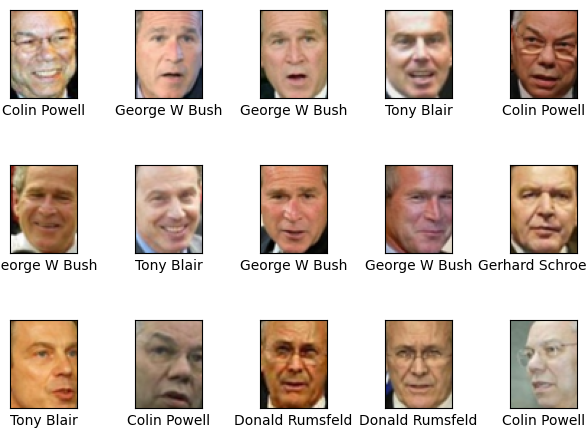

In [ ]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

# Preprocessing
Kode di bawah melakukan normalisasi dan resizing gambar pada dataset LFW. Gambar pertama kali dinormalisasi dengan membagi setiap nilai piksel dengan 255.0, sehingga nilainya berada dalam rentang 0 hingga 1. Selanjutnya, fungsi resize_images digunakan untuk mengubah ukuran gambar menjadi 64x64 piksel menggunakan OpenCV (cv2.resize). Setelah gambar diubah ukurannya, dimensi baru dari data gambar dicetak. Terakhir, gambar-gambar dari dataset divisualisasikan menggunakan matplotlib, di mana 15 gambar dipilih secara acak dan ditampilkan dalam grid 3x5, lengkap dengan label nama orang yang bersangkutan.

Data dimension: (1140, 64, 64, 3)


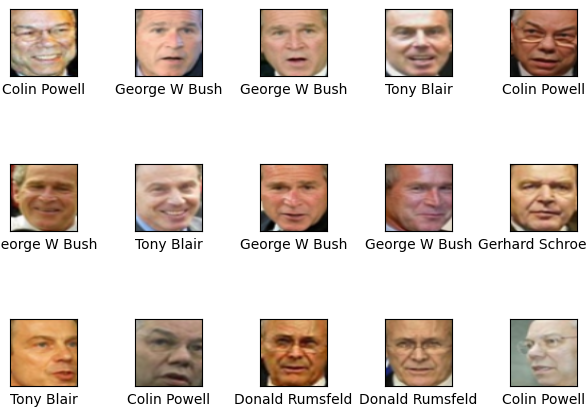

In [ ]:
# Normalisasi pixel (fitur) ke rentang 0-1
faces.data = faces.data / 255.0

# Meresize gambar
def resize_images(images, size=(64, 64)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, size)
        resized_images.append(resized_img)
    return np.array(resized_images)

faces.images = resize_images(faces.images)
print(f'Data dimension: {faces.images.shape}')

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

# Features Extraction
Kode di bawah membuat fungsi extract_histogram untuk menghitung histogram dari gambar RGB dalam dataset. Histogram tersebut dihitung secara terpisah untuk setiap channel warna (merah, hijau, dan biru) menggunakan fungsi np.histogram, yang menghasilkan distribusi intensitas warna untuk setiap channel. Histogram dari ketiga channel kemudian digabungkan menjadi satu vektor fitur.

Setelah itu, fungsi tersebut diterapkan pada semua gambar dalam dataset untuk mengekstraksi fitur histogram. Fitur histogram ini disimpan dalam array hist_features, dan contoh pertama dari hasil fitur serta dimensi dari semua fitur histogram dicetak untuk verifikasi.

In [ ]:
# Fungsi untuk menghitung histogram dari gambar RGB
def extract_histogram(image, bins=50):
    # Pisahkan channel warna (R, G, B)
    r_hist, _ = np.histogram(image[:, :, 0], bins=bins, range=(0, 256))
    g_hist, _ = np.histogram(image[:, :, 1], bins=bins, range=(0, 256))
    b_hist, _ = np.histogram(image[:, :, 2], bins=bins, range=(0, 256))

    # Gabungkan semua histogram menjadi satu fitur vektor
    hist_features = np.concatenate([r_hist, g_hist, b_hist])
    return hist_features

# Ekstraksi fitur histogram untuk semua gambar dalam dataset
# Menggunakan gambar RGB asli (bukan grayscale)
hist_features = np.array([extract_histogram(img) for img in faces.images])
print(hist_features[:5])
print(f"Shape of histogram features: {hist_features.shape}")

[[4096    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0 4096    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 4096    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [4096    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0

# Build Model
Kode di bawah membagi dataset menjadi data latih dan data uji menggunakan fungsi train_test_split. Data histogram gambar yang diekstraksi (hist_features) digunakan sebagai fitur (X), sementara faces.target digunakan sebagai label (y). Pembagian dilakukan dengan rasio 70:30 antara data latih dan data uji, serta dilakukan stratified sampling berdasarkan label untuk menjaga distribusi kelas yang seimbang.

Setelah itu, sebuah model Support Vector Machine (SVM) dengan kernel linear dibuat menggunakan fungsi SVC dari scikit-learn. Model ini kemudian dilatih (fit) menggunakan data latih (X_train dan y_train).

In [ ]:
# Pembagian dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(hist_features, faces.target, test_size=0.3, random_state=42,stratify=faces.target)

# Pembuatan objek model SVM
# Menggunakan kernel 'linear'
model_svm = SVC(kernel='linear', random_state=42)

# Proses fitting model menggunakan data training
model_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

# Evaluation
Kode di bawah mengevaluasi performa model SVM yang telah dilatih menggunakan data uji dan data latih. Pertama, model memprediksi label untuk data uji, dan akurasi serta laporan klasifikasi dihitung untuk membandingkan hasil prediksi dengan label sebenarnya. Selanjutnya, evaluasi serupa dilakukan pada data latih untuk mengidentifikasi kemungkinan overfitting. Outputnya mencakup akurasi dan metrik klasifikasi (precision, recall, dan F1-score) untuk setiap kelas dalam dataset, memberikan gambaran menyeluruh tentang efektivitas model dalam mengenali wajah.

In [ ]:
# Evaluasi model dengan data testing
y_pred_test = model_svm.predict(X_test)

print(f"Accuracy for histogram svc on test data: {accuracy_score(y_test, y_pred_test) * 100:.2f} %")
print("Classification report for histogram svc on test data:\n", classification_report(y_test, y_pred_test, target_names=faces.target_names, zero_division=0))

Accuracy for histogram svc on test data: 46.49 %
Classification report for histogram svc on test data:
                    precision    recall  f1-score   support

     Colin Powell       0.00      0.00      0.00        71
  Donald Rumsfeld       0.00      0.00      0.00        36
    George W Bush       0.46      1.00      0.63       159
Gerhard Schroeder       0.00      0.00      0.00        33
       Tony Blair       0.00      0.00      0.00        43

         accuracy                           0.46       342
        macro avg       0.09      0.20      0.13       342
     weighted avg       0.22      0.46      0.30       342



In [ ]:
# Evaluasi model dengan data training
y_pred_train = model_svm.predict(X_train)

print(f"Accuracy for histogram svc on test data: {accuracy_score(y_train, y_pred_train) * 100:.2f} %")
print("Classification report for histogram svc on test data:\n", classification_report(y_train, y_pred_train, target_names=faces.target_names, zero_division=0))

Accuracy for histogram svc on test data: 46.49 %
Classification report for histogram svc on test data:
                    precision    recall  f1-score   support

     Colin Powell       0.00      0.00      0.00       165
  Donald Rumsfeld       0.00      0.00      0.00        85
    George W Bush       0.46      1.00      0.63       371
Gerhard Schroeder       0.00      0.00      0.00        76
       Tony Blair       0.00      0.00      0.00       101

         accuracy                           0.46       798
        macro avg       0.09      0.20      0.13       798
     weighted avg       0.22      0.46      0.30       798



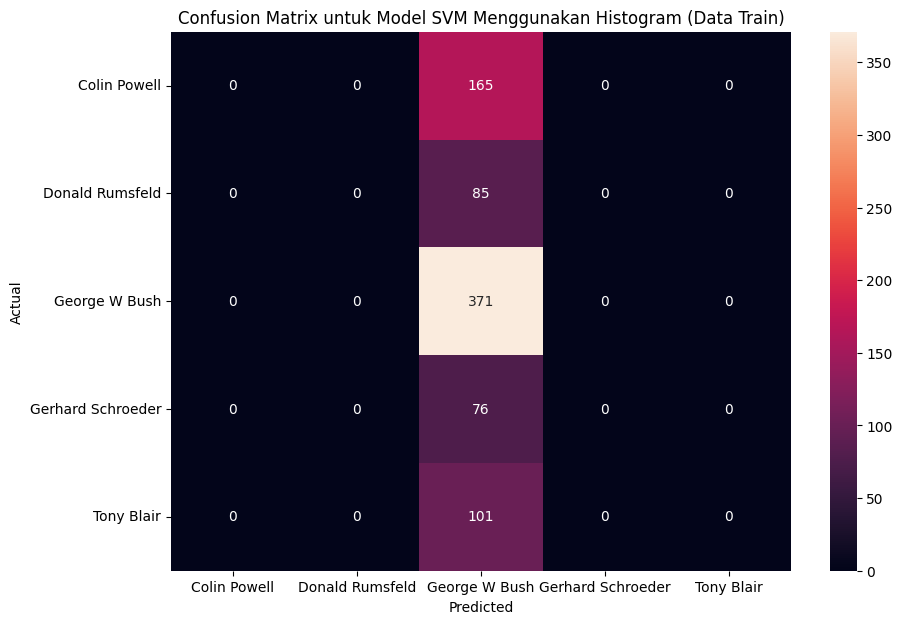

In [ ]:
# Menghitung dan menampilkan confusion matrix
confusion_mat_train = confusion_matrix(y_train, y_pred_train)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_train, annot=True, fmt='d',
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix untuk Model SVM Menggunakan Histogram (Data Train)')
plt.show()

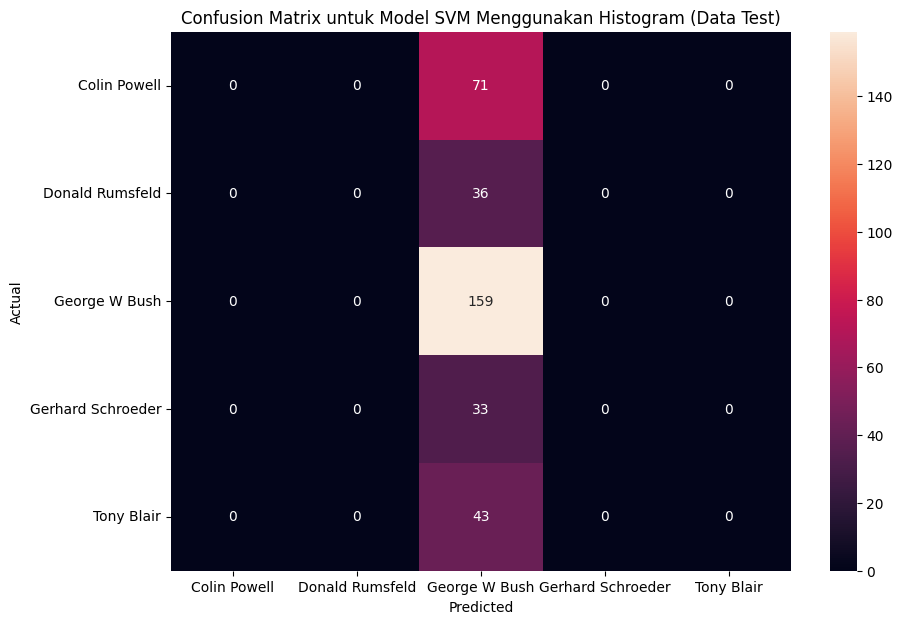

In [ ]:
# Menghitung dan menampilkan confusion matrix
confusion_mat_test = confusion_matrix(y_test, y_pred_test)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_test, annot=True, fmt='d',
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix untuk Model SVM Menggunakan Histogram (Data Test)')
plt.show()

# Challenge


# 1. Menghitung Fitur HOG untuk Setiap Gambar

Pada bagian ini, kita menghitung fitur HOG dari setiap gambar dalam dataset. HOG digunakan untuk menangkap informasi tentang tepi dan orientasi di setiap bagian gambar. Setiap gambar dibagi menjadi sel kecil berukuran 8x8 piksel, dan pada setiap sel, orientasi gradien dihitung untuk menentukan arah perubahan intensitas dalam gambar. Setelah itu, sel-sel ini dikelompokkan dalam blok yang terdiri dari 2x2 sel.

Untuk mendukung gambar RGB, kami menggunakan parameter channel_axis=-1, yang memastikan bahwa ketiga saluran warna diproses. Ini memungkinkan kita untuk menangkap informasi tepi dari semua saluran warna (merah, hijau, dan biru).

Kode ini menghitung fitur HOG untuk semua gambar dalam dataset dan menyimpannya dalam array X_hog. Setelah fitur dihitung, bentuk dari data HOG dicetak untuk memverifikasi jumlah fitur yang dihasilkan.

In [ ]:
from skimage.feature import hog

# Fungsi untuk menghitung HOG untuk setiap gambar
def compute_hog(image):
    # Menghitung HOG dan mengatur channel_axis=-1 untuk mendukung gambar RGB
    return hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1)

# Menghitung fitur HOG untuk semua gambar
X_hog = np.array([compute_hog(img) for img in faces.images])

# Mengecek ukuran data HOG
print(f"Shape of HOG features: {X_hog.shape}")


Shape of HOG features: (1140, 1764)


# 2. Membagi Dataset dan Melatih Model SVM dengan Fitur HOG

Setelah fitur HOG dihitung, dataset dibagi menjadi dua bagian: data latih (training set) dan data uji (test set). Pembagian ini dilakukan dengan menggunakan train_test_split, di mana 70% data digunakan untuk melatih model dan 30% digunakan untuk menguji performa model.

Kami kemudian melatih model Support Vector Machine (SVM) dengan kernel linear menggunakan fitur HOG yang telah diekstraksi. SVM sangat cocok untuk tugas klasifikasi, terutama ketika data memiliki dimensi yang tinggi, seperti dalam kasus ini, di mana fitur HOG memiliki banyak elemen per gambar.

Model SVM kemudian dilatih menggunakan data latih, dan setelah pelatihan selesai, kode mencetak pesan bahwa model telah berhasil dilatih.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Membagi dataset menjadi train-test split dengan fitur HOG
X_train_hog, X_test_hog, y_train, y_test = train_test_split(X_hog, faces.target, test_size=0.3, random_state=42)

# Melatih model SVM dengan fitur HOG
svm_model_hog = SVC(kernel='linear', random_state=42)
svm_model_hog.fit(X_train_hog, y_train)

# Mengecek apakah model telah terlatih dengan benar
print("Model SVM dengan HOG telah terlatih.")


Model SVM dengan HOG telah terlatih.


# 3. Evaluasi Model SVM dengan Fitur HOG

Setelah model SVM dilatih, langkah berikutnya adalah melakukan evaluasi terhadap performa model dengan menggunakan data uji. Model melakukan prediksi pada data uji, dan hasil prediksi dibandingkan dengan label sebenarnya dari dataset.

Untuk mengukur kinerja model, kami menghitung akurasi, yang merupakan proporsi prediksi yang benar terhadap total data uji. Dalam hal ini, akurasi model mencapai 92.40%, yang menunjukkan bahwa model berhasil mengklasifikasikan gambar wajah dengan baik.

Selain akurasi, kami juga menggunakan classification report yang memberikan informasi lebih rinci tentang precision, recall, dan F1-score untuk setiap kelas (atau kategori wajah). Ini membantu dalam memahami performa model dalam menangani setiap kelas secara individual, termasuk bagaimana model menangani kelas yang mungkin lebih sulit diklasifikasikan.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Prediksi pada set test
y_pred_hog = svm_model_hog.predict(X_test_hog)

# Menghitung akurasi dan menampilkan classification report
accuracy_hog = accuracy_score(y_test, y_pred_hog)
print(f"Akurasi Model SVM dengan HOG: {accuracy_hog * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred_hog, target_names=faces.target_names, zero_division = 0))


Akurasi Model SVM dengan HOG: 92.40%
Classification Report:
                   precision    recall  f1-score   support

     Colin Powell       0.97      0.97      0.97        78
  Donald Rumsfeld       0.84      0.82      0.83        38
    George W Bush       0.94      0.93      0.93       159
Gerhard Schroeder       0.96      0.87      0.91        30
       Tony Blair       0.83      0.95      0.89        37

         accuracy                           0.92       342
        macro avg       0.91      0.91      0.91       342
     weighted avg       0.93      0.92      0.92       342



# 4. Menampilkan Confusion Matrix untuk Model SVM dengan Fitur HOG

Bagian terakhir dari evaluasi model adalah menampilkan confusion matrix. Confusion matrix memberikan gambaran visual tentang prediksi yang benar dan salah yang dilakukan oleh model. Pada dasarnya, ini adalah tabel yang menunjukkan seberapa sering setiap kelas diprediksi dengan benar, dan seberapa sering mereka salah diklasifikasikan sebagai kelas lain.

Dengan menggunakan seaborn dan matplotlib, kami membuat heatmap dari confusion matrix, yang membantu dalam memahami kesalahan prediksi model. Warna pada heatmap memberikan indikasi visual tentang jumlah prediksi yang benar (diagonal utama) dan prediksi yang salah (di luar diagonal).

Visualisasi ini berguna untuk mengidentifikasi kelas yang mungkin sulit untuk diklasifikasikan oleh model, dan memberikan wawasan tambahan untuk meningkatkan performa model di masa mendatang.

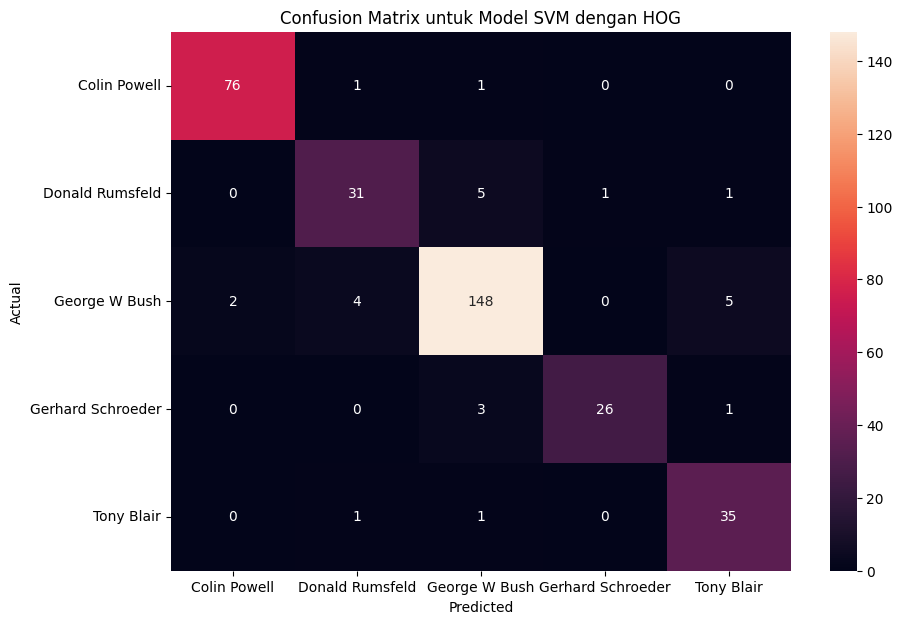

In [ ]:
# Menghitung dan menampilkan confusion matrix
confusion_mat_hog = confusion_matrix(y_test, y_pred_hog)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_hog, annot=True, fmt='d',
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix untuk Model SVM dengan HOG')
plt.show()

# Kesimpulan

Dengan menggunakan fitur HOG, model SVM dapat mencapai akurasi yang tinggi dalam klasifikasi wajah. HOG adalah fitur yang sangat kuat untuk menangkap pola tepi dalam gambar wajah, dan penggunaan SVM dengan kernel linear mampu memproses fitur tersebut dengan baik untuk melakukan klasifikasi dengan tingkat akurasi yang signifikan.








# Peparation
Kode di bawah mengimpor berbagai library. numpy dan pandas digunakan untuk manipulasi data, sedangkan fetch_lfw_people dari scikit-learn mengunduh dataset LFW (Labeled Faces in the Wild) yang berisi gambar wajah. train_test_split membagi data menjadi data latih dan uji.

Untuk evaluasi performa model, digunakan beberapa metrik seperti classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, dan roc_curve.

Model RandomForestClassifier dan KNeighborsClassifier digunakan untuk membangun model klasifikasi. label_binarize digunakan untuk mengonversi label menjadi format biner, sementara StandardScaler menormalkan data. PCA (Principal Component Analysis) digunakan untuk mengurangi dimensi data. Terakhir, matplotlib dan seaborn digunakan untuk visualisasi data serta hasil evaluasi.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Load Data
Kode di bawah memuat dataset LFW (Labeled Faces in the Wild) menggunakan fungsi fetch_lfw_people dengan parameter min_faces_per_person=100 dan gambar berwarna (color=True), yang memastikan hanya gambar orang yang memiliki setidaknya 100 foto akan dimuat.

In [ ]:
# Load LFW People dataset
faces = fetch_lfw_people(min_faces_per_person=100, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')


Total Label: 5
Data dimension: (1140, 62, 47, 3)
Images flatten dimension: (1140, 8742)


# Splitting Data & Normalization
Kode ini membagi dataset menjadi data latih dan data uji dengan perbandingan 80:20 menggunakan fungsi train_test_split, dan menyetel nilai acak menjadi 42 untuk memastikan hasil yang konsisten. Kemudian, data latih dan uji dinormalisasi menggunakan StandardScaler, yang menstandarkan fitur dengan mengurangi rata-rata dan membaginya dengan deviasi standar. Setelah itu, PCA (Principal Component Analysis) dengan 100 komponen digunakan untuk mengurangi dimensi data yang sudah distandardisasi, menghasilkan data latih dan uji dengan fitur yang lebih sedikit namun tetap mempertahankan informasi yang paling penting.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

# Fitting Random Forest Model
Mendefinisikan model klasifikasi Random Forest menggunakan RandomForestClassifier dengan 100 pohon keputusan (n_estimators=100) dan menetapkan random_state=42 untuk menjaga hasil yang konsisten setiap kali model dijalankan. Setelah itu, model dilatih menggunakan data latih yang telah melalui proses PCA (X_train_pca) dan label targetnya (y_train). Model ini akan belajar pola dari data latih yang nanti digunakan untuk memprediksi data baru.

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model dengan data pelatihan
rf_model.fit(X_train_pca, y_train)


RandomForestClassifier(random_state=42)

# Evalution

Kode ini menggunakan model Random Forest yang telah dilatih untuk memprediksi data uji (X_test_pca) dan menyimpan hasil prediksi di dalam y_pred_rf. Setelah itu, laporan klasifikasi ditampilkan menggunakan fungsi classification_report, yang memberikan metrik evaluasi seperti precision, recall, dan f1-score untuk setiap kelas berdasarkan label sebenarnya (y_test) dan prediksi model (y_pred_rf). Nama-nama target label wajah diambil dari faces.target_names.

Selanjutnya, akurasi model dihitung dengan fungsi accuracy_score, yang menunjukkan persentase prediksi yang benar yaitu 71.49%.

Kemudian memvisualisasikan confusion matrix untuk model Random Forest dengan menggunakan fungsi confusion_matrix, berdasarkan label sebenarnya (y_test) dan prediksi model (y_pred_rf).

In [ ]:
y_pred_rf = rf_model.predict(X_test_pca)

# Menampilkan laporan klasifikasi
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred_rf, target_names=faces.target_names, zero_division=0))

# Menampilkan akurasi
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Akurasi Model: {accuracy * 100:.2f}%")

Laporan Klasifikasi:
                   precision    recall  f1-score   support

     Colin Powell       0.92      0.72      0.81        50
  Donald Rumsfeld       0.88      0.28      0.42        25
    George W Bush       0.64      0.99      0.78       106
Gerhard Schroeder       0.67      0.18      0.29        22
       Tony Blair       1.00      0.44      0.61        25

         accuracy                           0.71       228
        macro avg       0.82      0.52      0.58       228
     weighted avg       0.77      0.71      0.68       228

Akurasi Model: 71.49%


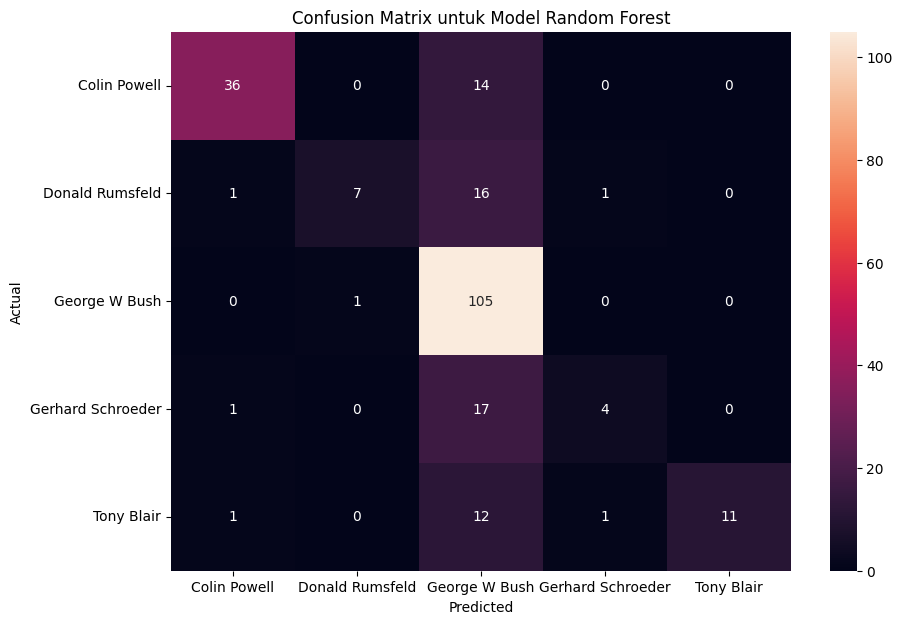

In [ ]:
# Menghitung dan menampilkan confusion matrix
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_rf, annot=True, fmt='d',
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix untuk Model Random Forest')
plt.show()

# Model KNN (K-Nearest Network)
Kode ini membuat model K-Nearest Neighbors (KNN) dengan 5 tetangga terdekat (n_neighbors=5) menggunakan fungsi KNeighborsClassifier. Setelah itu, model dilatih menggunakan data latih yang telah direduksi dimensinya dengan PCA (X_train_pca) dan label target (y_train). Model KNN ini akan memprediksi label data uji berdasarkan mayoritas label dari 5 tetangga terdekat di ruang fitur PCA.

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train_pca, y_train)

KNeighborsClassifier()

# Evaluation

Kode ini menggunakan model K-Nearest Neighbors (KNN) yang telah dilatih untuk memprediksi data uji (X_test_pca) dan menyimpan hasil prediksi dalam y_pred_knn. Setelah itu, laporan klasifikasi ditampilkan menggunakan fungsi classification_report, yang memberikan metrik evaluasi seperti precision, recall, dan f1-score untuk setiap kelas berdasarkan label sebenarnya (y_test) dan prediksi model (y_pred_knn). Nama-nama target label wajah diambil dari faces.target_names.

Selanjutnya, akurasi model dihitung dengan menggunakan fungsi accuracy_score, yang menunjukkan persentase prediksi yang benar. Dalam kasus ini, akurasi model KNN adalah 65.79%.

Kemudian memvisualisasikan confusion matrix untuk model K-Nearest Neighbors (KNN) dengan menggunakan fungsi confusion_matrix berdasarkan label sebenarnya (y_test) dan prediksi model (y_pred_knn).

In [ ]:
y_pred_knn = knn_model.predict(X_test_pca)

# Menampilkan laporan klasifikasi
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred_knn, target_names=faces.target_names, zero_division=0))

# Menampilkan akurasi
accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Akurasi Model: {accuracy * 100:.2f}%")

Laporan Klasifikasi:
                   precision    recall  f1-score   support

     Colin Powell       0.61      0.72      0.66        50
  Donald Rumsfeld       0.78      0.56      0.65        25
    George W Bush       0.68      0.81      0.74       106
Gerhard Schroeder       0.43      0.14      0.21        22
       Tony Blair       0.65      0.44      0.52        25

         accuracy                           0.66       228
        macro avg       0.63      0.53      0.56       228
     weighted avg       0.65      0.66      0.64       228

Akurasi Model: 65.79%


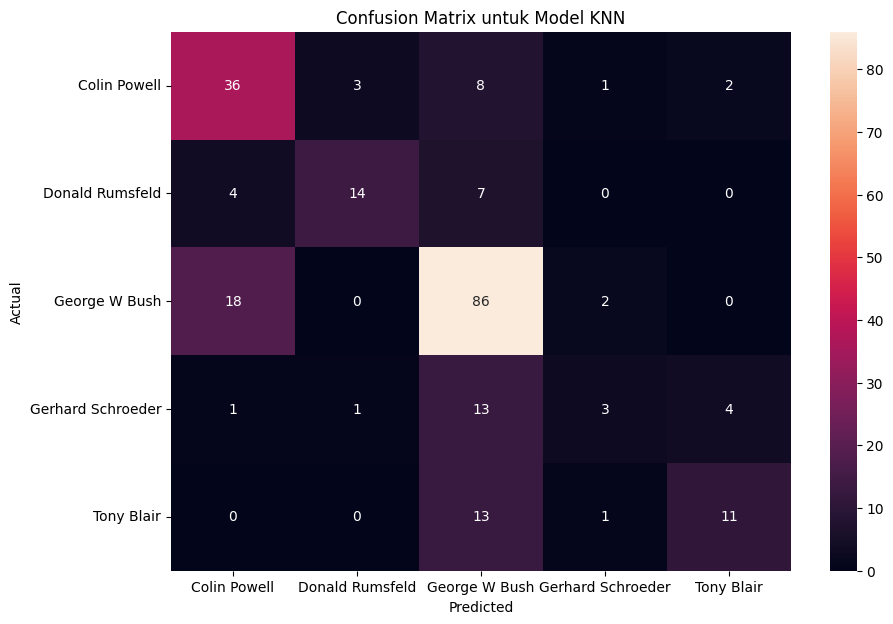

In [ ]:
# Menghitung dan menampilkan confusion matrix
confusion_mat_knn = confusion_matrix(y_test, y_pred_knn)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat_knn, annot=True, fmt='d',
            xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix untuk Model KNN')
plt.show()

# Kesimpulan

Berdasarkan hasil klasifikasi citra wajah menggunakan dataset Labeled Face in the Wild (LFW), diperoleh performa berbagai model yang cukup beragam. Berikut adalah kesimpulan yang dapat diambil dari hasil tersebut:

* Model SVM dengan Histogram menunjukkan performa yang kurang memuaskan, dengan akurasi hanya mencapai 46.49%. Ini menunjukkan bahwa metode histogram mungkin tidak cukup efektif untuk menangkap fitur yang relevan dalam pengenalan wajah.

* Model SVM dengan HOG (Histogram of Oriented Gradients) memberikan hasil yang sangat baik, dengan akurasi mencapai 92.40%. Hal ini menunjukkan bahwa HOG mampu menangkap informasi penting tentang struktur dan tepi wajah, yang berkontribusi signifikan terhadap peningkatan akurasi dalam klasifikasi.

* Model Random Forest menunjukkan akurasi sebesar 68.42%. Hal ini menunjukkan bahwa kombinasi fitur yang digunakan oleh Random Forest mungkin tidak optimal untuk dataset ini.

* Model KNN (K-Nearest Neighbors) menghasilkan akurasi 64.91%. Hasil ini menunjukkan bahwa KNN juga memiliki keterbatasan dalam menangkap fitur wajah yang relevan, terutama jika dibandingkan dengan SVM menggunakan HOG.

Secara keseluruhan, hasil ini menekankan pentingnya pemilihan fitur yang tepat dalam model klasifikasi wajah. SVM dengan HOG terbukti sebagai pendekatan paling efektif dalam pengenalan wajah dalam dataset ini, sementara penggunaan histogram dan KNN menunjukkan performa yang lebih rendah.